<a href="https://colab.research.google.com/github/VaibhavArya007/Product-Description-Generator-Model/blob/main/Product_Description_Using_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas langchain pinecone-client openai
!pip install langchain-community
!pip install -q -U torch datasets transformers tensorflow langchain playwright html2text sentence_transformers faiss-cpu
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7
!pip install -U langchain-community
!pip -qqq install langchain-groq==0.1.3 --progress-bar off
!pip install torch
!pip install transformers==4.10.3
!pip install sentence-transformers==2.1.0
!pip install sentence-transformers
!pip install sentence-transformers faiss-cpu langchain llama-index pandas
!pip install sentence-transformers faiss-cpu langchain llama-index pandas torch transformers
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
file1='/content/drive/MyDrive/new2.json'
file2= '/content/drive/MyDrive/delete.json'

In [2]:
import pandas as pd

file_path =file1

temp1 = pd.read_json(file_path, lines=True)

In [3]:
import pandas as pd

file_path = file2

temp2 = pd.read_json(file_path, lines=True)

In [4]:
df = pd.concat([temp1, temp2], ignore_index=True)

In [5]:
df.drop(columns=['question_id', 'asin'],inplace=True)
df_filtered = df[df['question_type'] != 'WH']

In [ ]:
df_filtered['points']=df_filtered['bullet_point1']+df_filtered['bullet_point2']+df_filtered['bullet_point3']+df_filtered['bullet_point4']+df_filtered['bullet_point5']

In [ ]:
df_filtered.drop(columns=['bullet_point1', 'bullet_point2', 'bullet_point3', 'bullet_point4', 'bullet_point5'],inplace=True)

In [ ]:
def merge_answers(answer_list):
    return ' '.join(d['answer_text'] for d in answer_list)

df_filtered['merged_answer'] = df_filtered['answers'].apply(merge_answers)

In [ ]:
df_filtered.drop(columns=['answers'],inplace=True)

In [ ]:
df_filtered['all_detail']=df_filtered['product_description']+df_filtered['brand_name']+df_filtered['item_name']+df_filtered['points']

In [ ]:
df_filtered.drop(columns=['product_description', 'brand_name', 'item_name', 'points', 'question_type'],inplace=True)

In [ ]:
df_filtered['final'] = df_filtered['all_detail'] + " " + df_filtered['merged_answer']

In [ ]:
df_filtered.drop(columns=['all_detail', 'merged_answer'],inplace=True)

In [14]:
df_final = pd.DataFrame(df_filtered['final'])

In [ ]:
category_counts = df_filtered['answer_aggregated'].value_counts().sum()
category_counts_ = df_filtered['answer_aggregated'].value_counts()
print(category_counts)

In [ ]:
category_counts_ = df_filtered['answer_aggregated'].value_counts()
print(category_counts_)

In [ ]:
neutral = 32959/72161
yes= 27130/72161
no= 1-(neutral+yes)
print (neutral, yes, no)

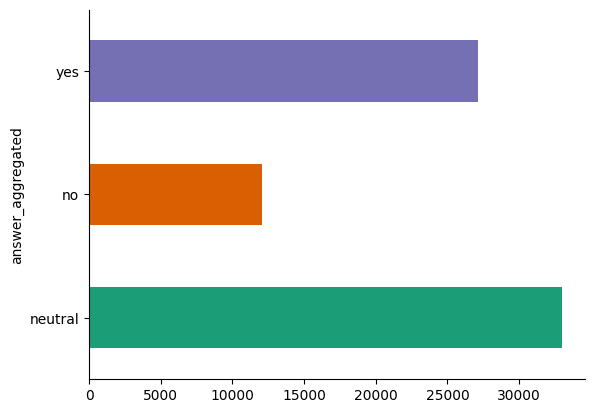

In [18]:
# @title answer_aggregated

from matplotlib import pyplot as plt
import seaborn as sns
df_filtered.groupby('answer_aggregated').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [19]:
import os
import torch
# from transformers import (
#     AutoModelForCausalLM,
#     AutoTokenizer,
#     # BitsAndBytesConfig,
#     pipeline
# )

from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

In [20]:
df_final_sampled = df_final.sample(250)

In [21]:
import os
import re
import requests
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

def format_response (response: str) -> str:
    entries = re.split(r" (?<=]), (?=\[)", response)
    return [entry.strip("[]") for entry in entries]

os.environ ["GROQ_API_KEY"] = "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"

In [22]:
mistral_llm = ChatGroq(temperature = 0.2,model_name="llama3-8b-8192")

In [23]:
alldata=" "
for index, row in df_final_sampled.iterrows():
  alldata = alldata + " " +  row['final']

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

def split_text_with_overlap(text, chunk_size=200, overlap=10):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start += (chunk_size - overlap)
    return chunks

# Example usage
  # Replace with your actual string
chunks = split_text_with_overlap(alldata, chunk_size=200, overlap=10)

# Printing the chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}:\n{chunk}\n")

In [25]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import faiss

In [ ]:
class HuggingFaceEmbeddings:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def encode(self, texts):
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()

# Instantiate the embeddings model
model_name = 'sentence-transformers/all-mpnet-base-v2'
hf_embeddings = HuggingFaceEmbeddings(model_name)

# Encode chunked documents
embeddings = hf_embeddings.encode([chunk for chunk in chunks])

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

In [27]:
from langchain.docstore.document import Document

In [28]:
class HuggingFaceEmbeddings:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def encode(self, texts):
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()

    def embed_documents(self, documents):
        texts = [doc for doc in documents]
        return self.encode(texts)

    def embed_query(self, query):
        inputs = self.tokenizer(query, return_tensors='pt')
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).detach().numpy()




In [29]:
model_name = 'sentence-transformers/all-mpnet-base-v2'
hf_embeddings = HuggingFaceEmbeddings(model_name)

In [ ]:
def retrieve(query, k=5):
    query_embedding = hf_embeddings.encode([query])
    distances, indices = index.search(query_embedding, 5)
    return [chunks[i] for i in indices[0]]

# Example retrieval
query = "How much is the battery life of laptop"
retrieved_docs = retrieve(query)
for doc in retrieved_docs:
    print(doc)
documents = [Document(page_content=chunk) for chunk in retrieved_docs]

db = FAISS.from_documents(documents, hf_embeddings)
retriever = db.as_retriever()

In [ ]:
def retrieve_chunks(query, index, hf_embeddings, documents, top_k=5):
    # Embed the query
    query_embedding = hf_embeddings.embed_query(query)

    # Search FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Check the lengths of indices and documents
    num_documents = len(documents)
    retrieved_chunks = []
    for idx in indices[0]:
        if idx < num_documents:
            retrieved_chunks.append(documents[idx].page_content)
        else:
            print(f"Index {idx} is out of bounds for documents list of length {num_documents}")

    return retrieved_chunks

# Example query
query = "what is the battery life of laptop"
retrieved_chunks = retrieve_chunks(query, index, hf_embeddings, documents)

# Print retrieved chunks
for i, chunk in enumerate(retrieved_chunks):
    print(f"Chunk {i+1}: {chunk}")



In [32]:
retriever = db.as_retriever()

In [ ]:
from langchain import PromptTemplate, LLMChain
from langchain_core.runnables import RunnablePassthrough
# Define the prompt template
prompt_template = """
note while returning final answer please print little bit of context from docs that you have used to generate answer
### [INST] Instruction: Answer the question based on your docs knowledge. Here is context to help:

{context}

### QUESTION:
{question} [/INST]
"""

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Assume mistral_llm is defined elsewhere, and it's the language model you are using
# Create llm chain
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

# Define a retriever function that retrieves context given a query
def retriever(query):
    # Example implementation using the previously defined retrieve_chunks function
    # Ensure index, hf_embeddings, and documents are properly defined
    return retrieve_chunks(query, index, hf_embeddings, documents)

# Create RAG chain
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | llm_chain
)

# Invoke the RAG chain
result = rag_chain.invoke("What is the best laptop")

# Print the result
print(result)


In [34]:
result['context']

[]

In [35]:
text = result['text']

# Add line breaks to format the text as a paragraph
formatted_text = text.replace('\n', ' ')  # Replace existing line breaks with spaces
formatted_text = formatted_text.replace('. ', '.\n\n')  # Add double line breaks after periods

# Print the formatted text
print(formatted_text)

Based on my documentation knowledge, the "best" laptop is subjective and depends on various factors such as budget, usage, and personal preferences.

However, here are some top-rated laptops across different categories:  **For general use:**  * Dell XPS 13: A popular choice for its sleek design, long battery life, and powerful performance.

(Source: CNET) * Apple MacBook Air: A great option for those invested in the Apple ecosystem, offering a seamless user experience and impressive battery life.

(Source: The Verge)  **For gaming:**  * Razer Blade 15: A top-notch gaming laptop with a powerful NVIDIA GeForce GPU, fast processor, and customizable backlighting.

(Source: PCMag) * MSI GS65 Stealth: A slim and lightweight gaming laptop with a powerful Intel Core i9 processor and NVIDIA GeForce GTX 1070 graphics.

(Source: Laptop Mag)  **For budget-conscious buyers:**  * Acer Aspire 3: A budget-friendly laptop with a decent processor, ample storage, and a long-lasting battery.

(Source: Tec